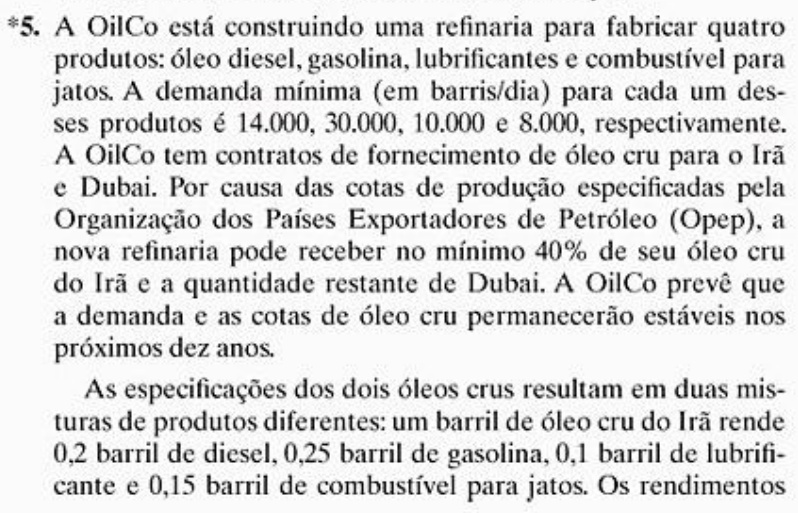

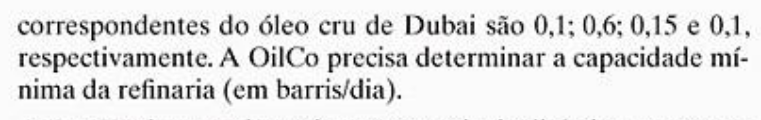

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Capacidade_Minima_Refinaria_OilCo')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Fontes de óleo cru e produtos finais
fontes_cru = ['ira', 'dubai']
produtos = ['diesel', 'gasolina', 'lubrificantes', 'jatos']

# Demanda mínima diária (em barris) para cada produto
demanda_minima = {
    'diesel': 14000,
    'gasolina': 30000,
    'lubrificantes': 10000,
    'jatos': 8000
}

# Rendimento (barris de produto por barril de óleo cru)
# Estrutura: rendimento[fonte][produto]
rendimento = {
    'ira':   {'diesel': 0.20, 'gasolina': 0.25, 'lubrificantes': 0.10, 'jatos': 0.15},
    'dubai': {'diesel': 0.10, 'gasolina': 0.60, 'lubrificantes': 0.15, 'jatos': 0.10}
}

# Cota mínima de fornecimento (OPEP)
cota_minima_ira = 0.40 # 40%

In [4]:
# 1. Variáveis de Decisão
# Barris de cada tipo de óleo cru a serem processados por dia
barris_por_dia = model.continuous_var_dict(fontes_cru, name='Barris')


# 2. Função Objetivo
# Minimizar a capacidade total da refinaria (total de óleo cru processado)
expressao_capacidade = (barris_por_dia[f] for f in fontes_cru)
capacidade_total = model.sum(expressao_capacidade)
model.minimize(capacidade_total)


# 3. Restrições

# Restrição 1: Atender à Demanda Mínima de Cada Produto
for p in produtos:
    expressao_producao = (rendimento[f][p] * barris_por_dia[f] for f in fontes_cru)
    soma_producao_produto = model.sum(expressao_producao)
    restr_demanda_logica = soma_producao_produto >= demanda_minima[p]
    model.add_constraint(restr_demanda_logica, ctname=f'demanda_{p}')

# Restrição 2: Cota Mínima de Óleo do Irã
# O óleo do Irã (I) deve ser no mínimo 40% do total (I+D)
# I >= 0.4 * (I + D)  =>  I >= 0.4*I + 0.4*D  =>  0.6*I - 0.4*D >= 0
restr_cota_logica = 0.6 * barris_por_dia['ira'] - 0.4 * barris_por_dia['dubai'] >= 0
model.add_constraint(restr_cota_logica, ctname='cota_ira_minima')

docplex.mp.LinearConstraint[cota_ira_minima](0.600Barris_ira-0.400Barris_dubai,GE,0)

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
print(solucao)

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         50000.000000

------ SOLUÇÃO ÓTIMA ------

solution for: Capacidade_Minima_Refinaria_OilCo
objective: 85000
status: OPTIMAL_SOLUTION(2)
Barris_ira=55000.000
Barris_dubai=30000.000

